In [1]:
import tables_io
import numpy as np
import matplotlib.pyplot as plt
import qp
import pyccl as ccl

In [2]:
# pz_dir = '/global/cfs/cdirs/lsst/groups/PZ/DP1'
# if that fails you can use this
# pz_dir = '/global/u2/e/echarles/dx'
pz_dir = '/Users/echarles/pz'

In [3]:
ot = tables_io.read(f'{pz_dir}/sandbox_data/ecdfs/lsst_cat_matched_nonan_train.hdf5')
t = ot

In [4]:
def r_90_of_n(n):
    return 1.25 + 1.125*n

In [114]:
cosmo = ccl.Cosmology(
    Omega_c=0.25, Omega_b=0.05,
    h=0.7, n_s=0.95, sigma8=0.8,
    transfer_function='bbks'
)
z_grid = np.linspace(0., 6., 301)[1:]
a_grid = (1/(1+z_grid))
D_a = cosmo.angular_diameter_distance(a_grid)
rad_to_asec = 360*60*60/(2*np.pi) 
ang_scale_z = D_a * 1000/ rad_to_asec
dist_mod = cosmo.distance_modulus(a_grid)

In [115]:
mask  = (t['refExtendedness'] == 1) *\
        (t['i_blendedness'] < 0.01) *\
        (t['g_psfFlux']/ t['g_psfFluxErr'] > 10) *\
        (t['i_psfFlux'] / t['i_psfFluxErr'] > 10) *\
        (t['r_psfFlux'] / t['r_psfFluxErr'] > 10) *\
        (t['z_psfFlux'] / t['z_psfFluxErr'] > 10)



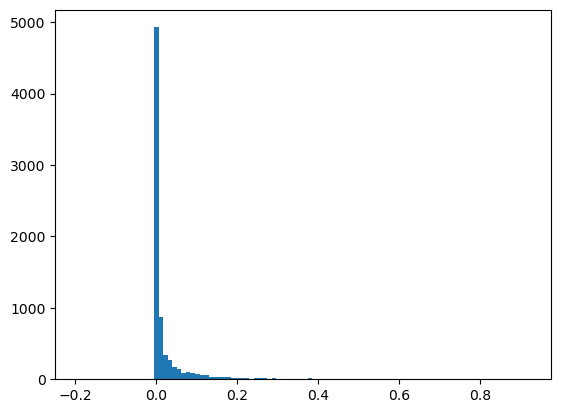

In [116]:
_ = plt.hist(t['i_blendedness'], bins=100)

In [117]:
sersic_x = ot['sersic_reff_x']
sersic_y = ot['sersic_reff_y']
sersic_index = ot['sersic_index']
sersic_ratio = r_90_of_n(sersic_index)
sersic_chord = np.sqrt(sersic_x*sersic_x + sersic_y*sersic_y)
spiral_mask = sersic_index < 3
ellip_mask = sersic_index > 3

In [118]:
mag = ot['i_sersicMag']
psfmag = ot['i_psfMag']

In [119]:
redshifts = ot['redshift']
redshifts = np.where(np.isfinite(redshifts), redshifts, 9).clip(0.0001, 10.)

scale = 1/(1+redshifts)
scale = np.where(np.isfinite(scale), scale, 0.1)

In [120]:
D_a_vals = cosmo.angular_diameter_distance(scale)
rad_to_asec = 360*60*60/(2*np.pi) 
ang_scale = D_a_vals * 1000/ rad_to_asec
dist_mods = cosmo.distance_modulus(scale)

In [121]:
traces = {}
for band in 'ugrizy':
   traces[band] = ot[f"{band}_ixx"] + ot[f"{band}_iyy"]


In [122]:
chords = {}
for band in 'ugrizy':
   chords[band] = np.sqrt(ot[f"{band}_ixx"] + ot[f"{band}_iyy"])

chords2d = np.vstack( [chords[band] for band in 'griz'] )
chord_scatter = np.var(chords2d, axis=0)
chord_mean = np.mean(chords2d, axis=0)

In [123]:
g_z_size_ratio = np.log10(chords['g'] / chords['z'])
g_z_1p0_color_diff = (ot['g_psfMag'] - ot['z_psfMag']) - (ot['g_gaap1p0Mag'] - ot['z_gaap1p0Mag'])
g_z_1p5_color_diff = (ot['g_psfMag'] - ot['z_psfMag']) - (ot['g_gaap1p5Mag'] - ot['z_gaap1p5Mag'])
g_z_2p5_color_diff = (ot['g_psfMag'] - ot['z_psfMag']) - (ot['g_gaap2p5Mag'] - ot['z_gaap2p5Mag'])
g_z_3p0_color_diff = (ot['g_psfMag'] - ot['z_psfMag']) - (ot['g_gaap3p0Mag'] - ot['z_gaap3p0Mag'])
size_mask = np.bitwise_and(
    np.bitwise_and(
        np.isfinite(g_z_size_ratio[mask]),
        np.isfinite(g_z_2p5_color_diff[mask]),
    ),
    np.isfinite(g_z_3p0_color_diff[mask]),
)


In [124]:
np.corrcoef(g_z_size_ratio[mask][size_mask], g_z_1p0_color_diff[mask][size_mask])[1,0]

np.float64(0.6189111533502816)

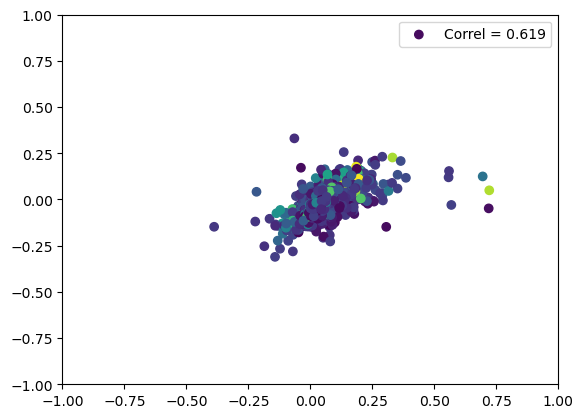

In [125]:
correl = np.corrcoef(g_z_size_ratio[mask][size_mask], g_z_1p0_color_diff[mask][size_mask])[1,0]
_ = plt.scatter(g_z_size_ratio[mask], g_z_1p0_color_diff[mask], c=redshifts[mask], label=f"Correl = {correl:0.3f}")
_ = plt.xlim(-1, 1)
_ = plt.ylim(-1, 1)
_ = plt.legend()

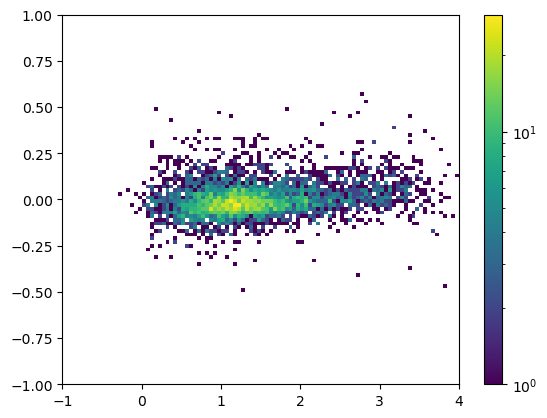

In [126]:
#_ = plt.scatter((t['g_psfMag'] - t['z_psfMag'])[mask], g_z_1p5_color_diff[mask], c=redshifts[mask], s=1)
_ = plt.hist2d((t['g_psfMag'] - t['z_psfMag'])[mask], g_z_1p5_color_diff[mask], bins=(np.linspace(-1,4, 101), np.linspace(-1,1,101)), norm='log')

_ = plt.xlim(-1, 4)
_ = plt.ylim(-1, 1)
_ = plt.colorbar()

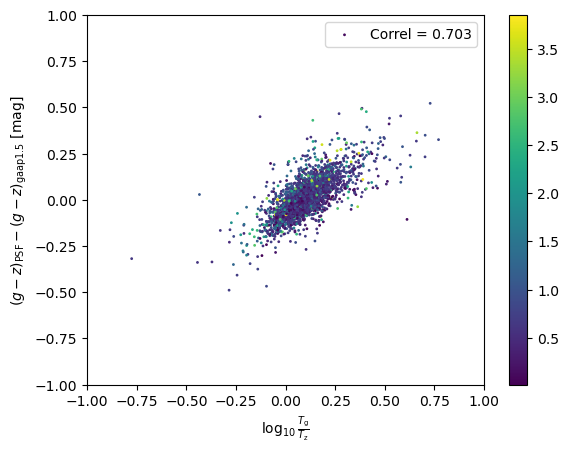

In [127]:
correl = np.corrcoef(2*g_z_size_ratio[mask][size_mask], g_z_1p5_color_diff[mask][size_mask])[1,0]
_ = plt.scatter(2*g_z_size_ratio[mask], g_z_1p5_color_diff[mask], c=redshifts[mask], s=1, label=f"Correl = {correl:0.3f}")
_ = plt.xlim(-1, 1)
_ = plt.ylim(-1, 1)
_ = plt.legend()
_ = plt.colorbar()
_ = plt.xlabel(r'$\log_{10}{\frac{T_{\rm g}}{T_{\rm z}}}$')
_ = plt.ylabel(r'$(g-z)_{\rm PSF} - (g-z)_{\rm gaap 1.5}$ [mag]')

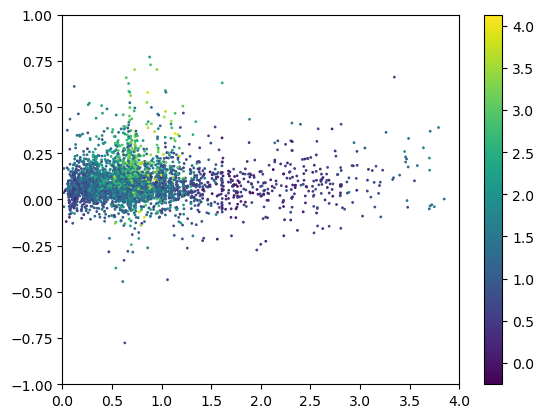

In [128]:
_ = plt.scatter(redshifts[mask], 2*g_z_size_ratio[mask], c=(t['g_psfMag']-t['z_psfMag'])[mask], s=1)
_ = plt.colorbar()
_ = plt.xlim(0, 4)
_ = plt.ylim(-1, 1)

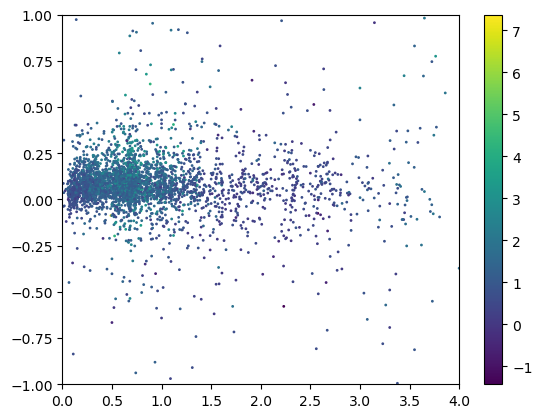

In [129]:
_ = plt.scatter(redshifts[spiral_mask], 2*g_z_size_ratio[spiral_mask], c=(t['g_psfMag']-t['z_psfMag'])[spiral_mask], s=1)
_ = plt.colorbar()
_ = plt.xlim(0, 4)
_ = plt.ylim(-1, 1)

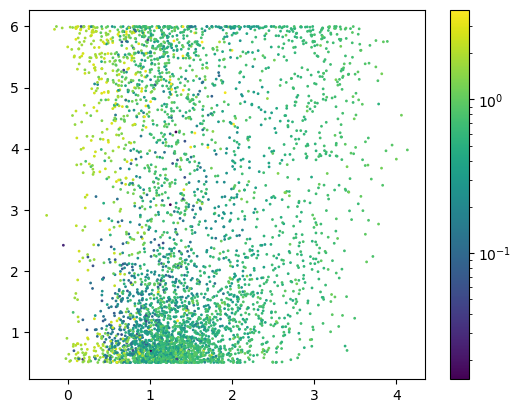

In [130]:
_ = plt.scatter((t['g_psfMag']-t['z_psfMag'])[mask], sersic_index[mask], c=redshifts[mask], s=1, norm='log')
_ = plt.colorbar()

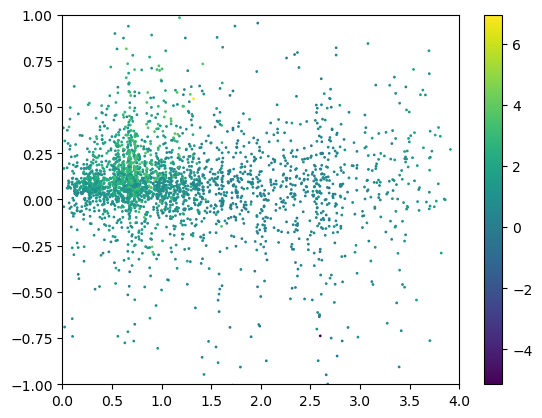

In [131]:
_ = plt.scatter(redshifts[ellip_mask], 2*g_z_size_ratio[ellip_mask], c=(t['g_psfMag']-t['z_psfMag'])[ellip_mask], s=1)
_ = plt.colorbar()
_ = plt.xlim(0, 4)
_ = plt.ylim(-1, 1)

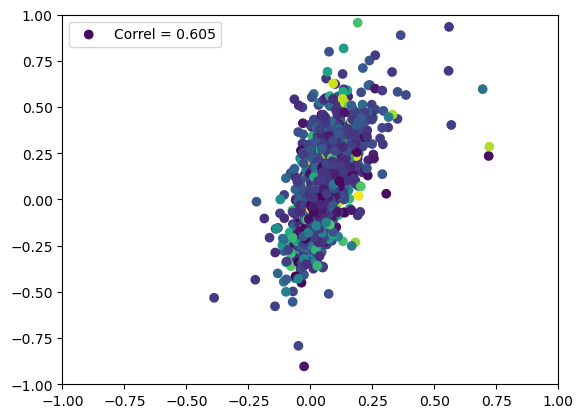

In [132]:
correl = np.corrcoef(g_z_size_ratio[mask][size_mask], g_z_2p5_color_diff[mask][size_mask])[1,0]
_ = plt.scatter(g_z_size_ratio[mask], g_z_2p5_color_diff[mask], c=redshifts[mask], label=f"Correl = {correl:0.3f}")
_ = plt.xlim(-1, 1)
_ = plt.ylim(-1, 1)
_ = plt.legend()

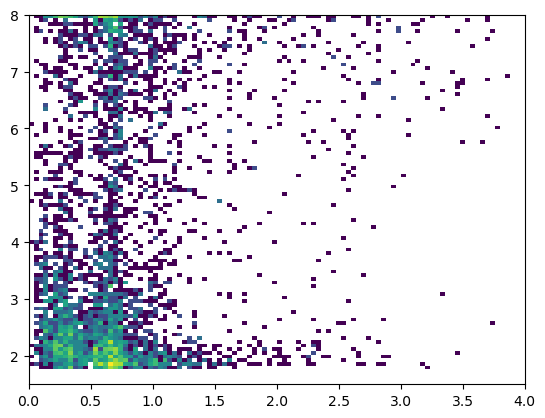

In [133]:
_ = plt.hist2d(redshifts[mask], sersic_ratio[mask], bins=(np.linspace(0.,4.,101), np.linspace(1.5, 8., 101)), norm='log')

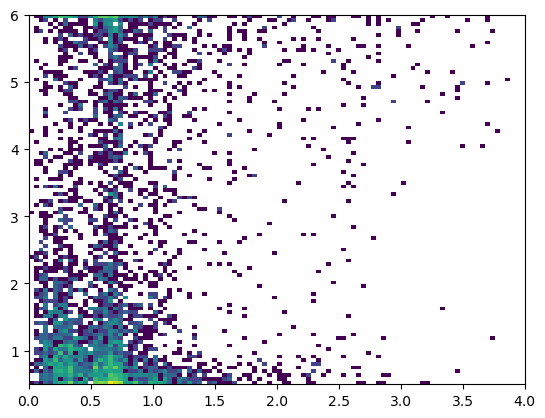

In [134]:
_ = plt.hist2d(redshifts[mask], sersic_index[mask], bins=(np.linspace(0.,4.,101), np.linspace(0.5, 6., 101)), norm='log')

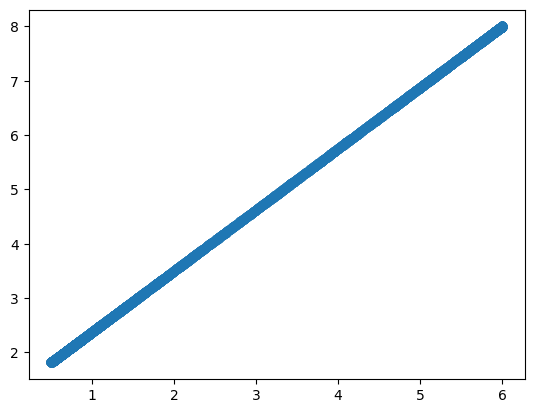

In [135]:
_ = plt.scatter(sersic_index[mask], sersic_ratio[mask])

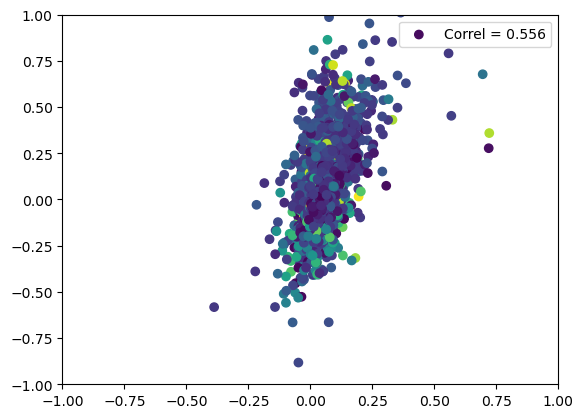

In [136]:
correl = np.corrcoef(g_z_size_ratio[mask][size_mask], g_z_3p0_color_diff[mask][size_mask])[1,0]
_ = plt.scatter(g_z_size_ratio[mask], g_z_3p0_color_diff[mask], c=redshifts[mask], label=f"Correl = {correl:0.3f}")
_ = plt.xlim(-1, 1)
_ = plt.ylim(-1, 1)
_ = plt.legend()

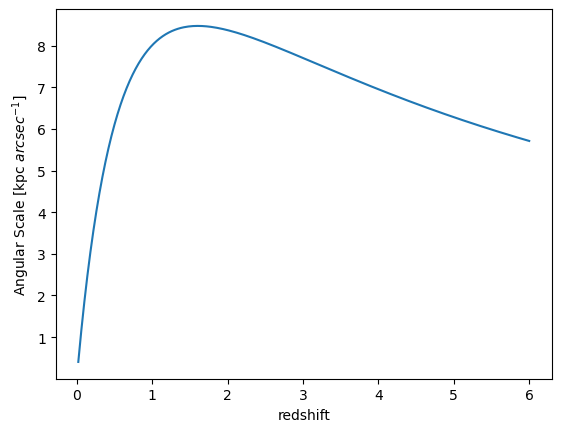

In [137]:
_ = plt.plot(z_grid, ang_scale_z)
_ = plt.ylabel(r'Angular Scale [kpc $arcsec^{-1}$]')
_ = plt.xlabel('redshift')

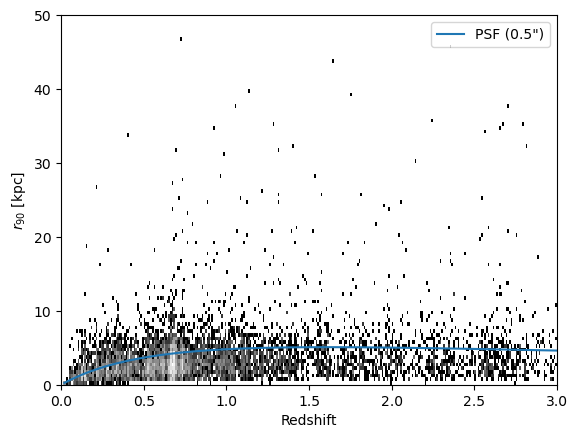

In [138]:
_ = plt.hist2d(redshifts, sersic_chord*0.2*ang_scale, bins=(np.linspace(0., 3., 301), np.linspace(0, 50, 101)), norm='log', cmap='gray')
_ = plt.xlabel('Redshift')
_ = plt.ylabel(r'$r_{90}$ [kpc]')
_ = plt.plot(z_grid, 0.6*ang_scale_z, label="PSF (0.5\")")
_ = plt.legend()

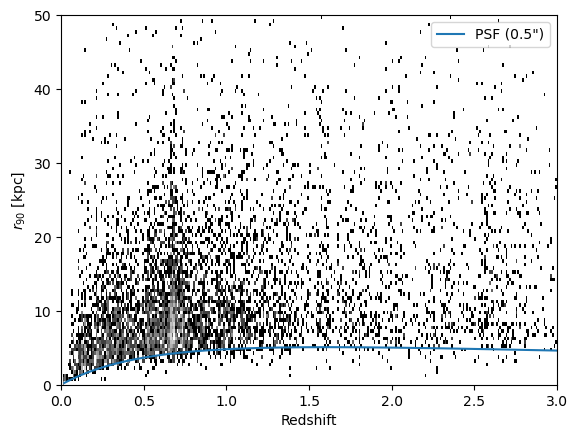

In [139]:
_ = plt.hist2d(redshifts, sersic_ratio*sersic_chord*0.2*ang_scale, bins=(np.linspace(0., 3., 301), np.linspace(0, 50, 101)), norm='log', cmap='gray')
_ = plt.xlabel('Redshift')
_ = plt.ylabel(r'$r_{90}$ [kpc]')
_ = plt.plot(z_grid, 0.6*ang_scale_z, label="PSF (0.5\")")
_ = plt.legend()

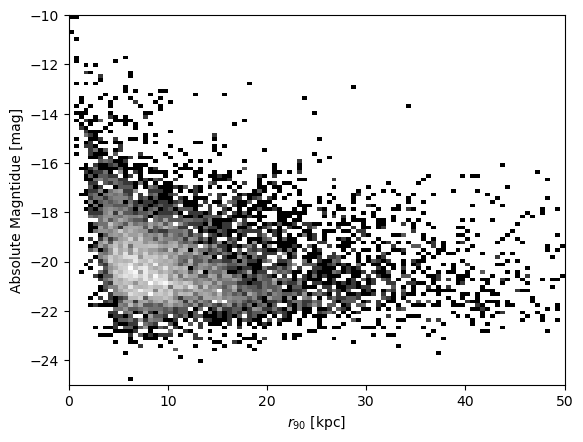

In [140]:
_ = plt.hist2d(sersic_ratio*sersic_chord*0.2*ang_scale, psfmag-dist_mods, bins=(np.linspace(0, 50, 101), np.linspace(-25, -10, 101)), norm='log', cmap='gray')
_ = plt.ylabel('Absolute Magntidue [mag]')
_ = plt.xlabel(r'$r_{90}$ [kpc]')

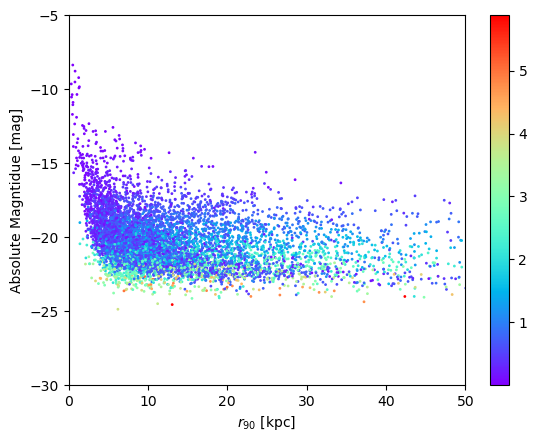

In [141]:
_ = plt.scatter(sersic_ratio*sersic_chord*0.2*ang_scale, mag-dist_mods, c=redshifts, cmap='rainbow', s=1)
_ = plt.ylim(-30, -5)
_ = plt.xlim(0, 50)
_ = plt.xlabel(r'$r_{90}$ [kpc]')
_ = plt.ylabel('Absolute Magntidue [mag]')
_ = plt.colorbar()

In [142]:
mask_lo = redshifts < 1
mask_hi = redshifts > 1

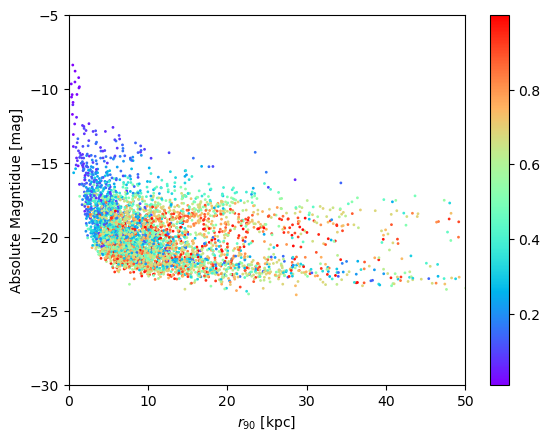

In [143]:
_ = plt.scatter((sersic_ratio*sersic_chord*0.2*ang_scale)[mask_lo], (mag-dist_mods)[mask_lo], c=redshifts[mask_lo], cmap='rainbow', s=1)
_ = plt.ylim(-30, -5)
_ = plt.xlim(0, 50)
_ = plt.xlabel(r'$r_{90}$ [kpc]')
_ = plt.ylabel('Absolute Magntidue [mag]')
_ = plt.colorbar()

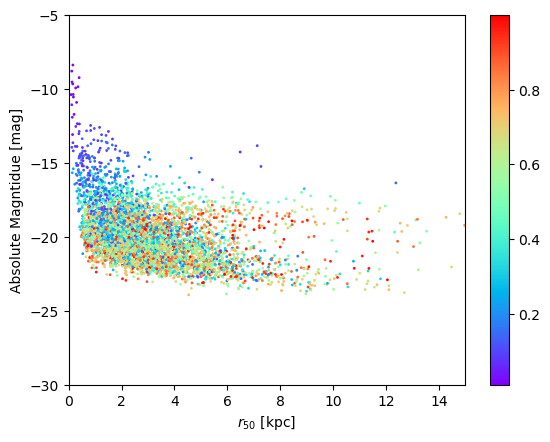

In [144]:
_ = plt.scatter((sersic_chord*0.2*ang_scale)[mask_lo], (mag-dist_mods)[mask_lo], c=redshifts[mask_lo], cmap='rainbow', s=1)
_ = plt.ylim(-30, -5)
_ = plt.xlim(0, 15)
_ = plt.xlabel(r'$r_{50}$ [kpc]')
_ = plt.ylabel('Absolute Magntidue [mag]')
_ = plt.colorbar()

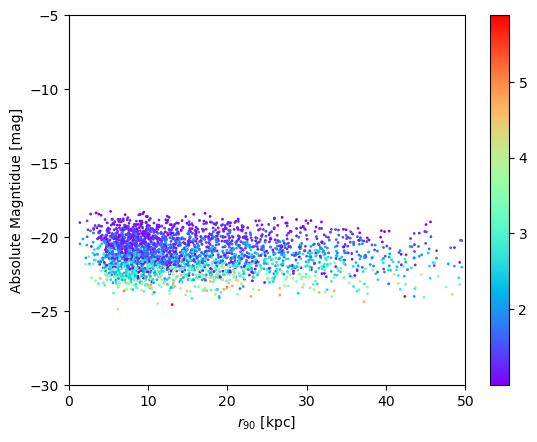

In [145]:
_ = plt.scatter((sersic_ratio*sersic_chord*0.2*ang_scale)[mask_hi], (mag-dist_mods)[mask_hi], c=redshifts[mask_hi], cmap='rainbow', s=1)
_ = plt.ylim(-30, -5)
_ = plt.xlim(0, 50)
_ = plt.xlabel(r'$r_{90}$ [kpc]')
_ = plt.ylabel('Absolute Magntidue [mag]')
_ = plt.colorbar()

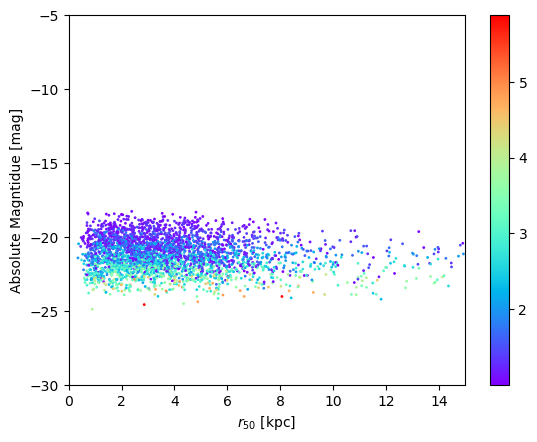

In [146]:
_ = plt.scatter((sersic_chord*0.2*ang_scale)[mask_hi], (mag-dist_mods)[mask_hi], c=redshifts[mask_hi], cmap='rainbow', s=1)
_ = plt.ylim(-30, -5)
_ = plt.xlim(0, 15)
_ = plt.xlabel(r'$r_{50}$ [kpc]')
_ = plt.ylabel('Absolute Magntidue [mag]')
_ = plt.colorbar()

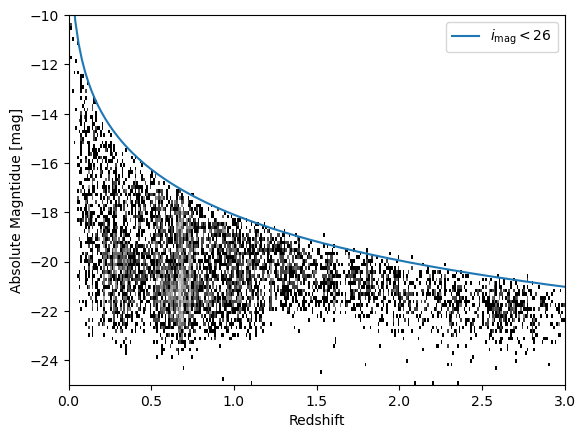

In [147]:
_ = plt.hist2d(redshifts, mag-dist_mods, bins=(np.linspace(0., 3., 301), np.linspace(-25, -10, 101)), norm='log', cmap='gray')
_ = plt.plot(z_grid, 26.0-dist_mod, label=r'$i_{\rm mag} < 26$')
_ = plt.xlabel('Redshift')
_ = plt.ylabel('Absolute Magntidue [mag]')
_ = plt.legend()

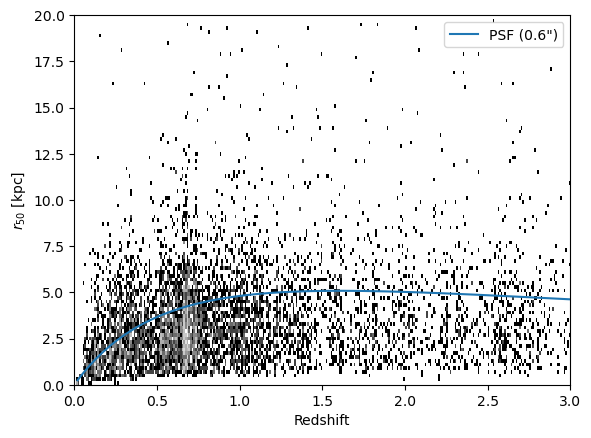

In [148]:
_ = plt.hist2d(redshifts, sersic_chord*0.2*ang_scale, bins=(np.linspace(0., 3., 301), np.linspace(0, 20, 101)), norm='log', cmap='gray')
_ = plt.xlabel('Redshift')
_ = plt.ylabel(r'$r_{50}$ [kpc]')
_ = plt.plot(z_grid, 0.6*ang_scale_z, label="PSF (0.6\")")
_ = plt.legend()

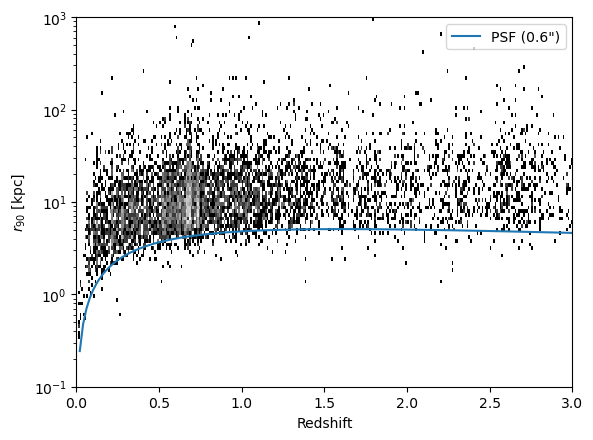

In [149]:
_ = plt.hist2d(redshifts, sersic_ratio*sersic_chord*0.2*ang_scale, bins=(np.linspace(0., 3., 301), np.logspace(-1, 3, 101)), norm='log', cmap='gray')
_ = plt.xlabel('Redshift')
_ = plt.ylabel(r'$r_{90}$ [kpc]')
_ = plt.yscale('log')
_ = plt.plot(z_grid, 0.6*ang_scale_z, label="PSF (0.6\")")
_ = plt.legend()

In [ ]:
chord_mean

In [ ]:
_ = plt.hist2d(chord_mean, sersic_chord, bins=(np.linspace(0, 15, 101), np.linspace(0, 15, 101)), norm='log', cmap='gray')